In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from numpy import asarray
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder
%matplotlib inline 

In [2]:
def load_image_into_numpy_array(path):

  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
 
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    #plt.imsave(image_name, image_np_with_annotations)
    plt.title(image_name)
    plt.imshow(image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [4]:
# Get name os astropi images
import os
data_folder = '../data/'
astro_data = os.listdir(data_folder)
astro_images_file = [file for file in astro_data if os.path.splitext(file)[1] != '.xml'] # remove xml file
astro_images_file.sort()

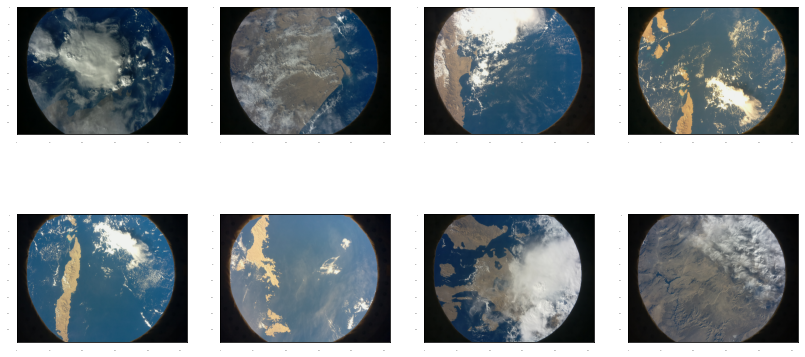

In [5]:
# Load images and visualize Astro Pi Data

astro_images_np = []
for image_name in astro_images_file:
  image_path = data_folder+image_name
  astro_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, image_np in enumerate(astro_images_np):
  plt.subplot(2, 4, idx+1)
  plt.imshow(image_np)
plt.show()

# PIL vs OpenCV vs TF.io

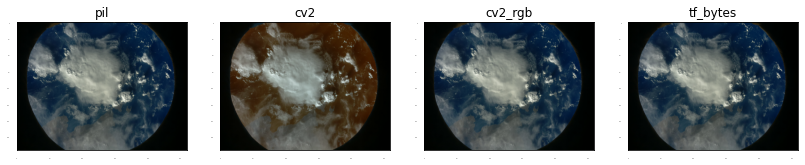

In [6]:
# Get Sample Data
image_name = "zz_astropi_1_photo_189.jpg"
image_path = data_folder +  image_name

# Show Earth 0 as PIL image 
from numpy import asarray
img_pil = Image.open(image_path) # PIL image
img_pil_np = asarray(img_pil) # convert to numpy array

# Show Earth 0 as cv2 image
import cv2 
img_cv2 = cv2.imread(image_path) # numpy array in BGR format
img_cv2_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB) # numpy array in RGB format

# Read image with Tensorflow io utils to get bytes
img_data = tf.io.gfile.GFile(image_path, 'rb').read()
img_bytes_pil = Image.open(BytesIO(img_data))
img_bytes_pil_np = asarray(img_bytes_pil)

# Show PIL np image, cv2 BGR, cv2 RGB image using matplotlib
images_np = [img_pil_np,img_cv2,img_cv2_rgb,img_bytes_pil_np]
images_np_title = ["pil","cv2","cv2_rgb","tf_bytes"]

for idx, image in enumerate(images_np):
  plt.subplot(2, 4, idx+1)
  plt.title(images_np_title[idx])
  plt.imshow(image)
plt.show()


## Annotation

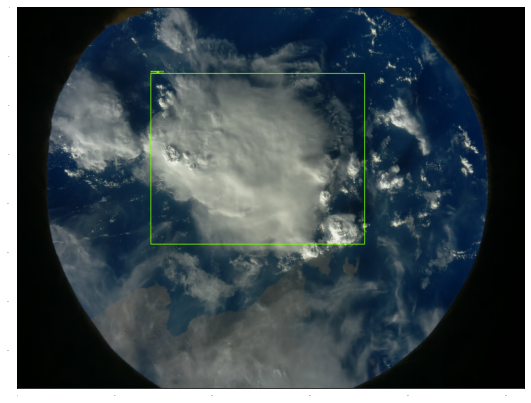

In [7]:
# Class Id
cloud_class_id = 0
water_class_id = 1
ground_class_id = 2


# Category Index
category_index = {
  cloud_class_id: {'id': cloud_class_id, 'name': 'cloud'},
  water_class_id: {'id': water_class_id, 'name': 'water'},
  ground_class_id: {'id': ground_class_id, 'name': 'ground'},
}

# Visualizing Cloud annotation on earth_O
gt_earth0 = [339,682,1209,1774]

width, heigth = img_pil.size

gt_earth0_normalized = [339/width,682/heigth,1209/width,1774/heigth]

gt_earth0_box = np.array([gt_earth0], dtype=np.float32)
gt_earth0_box

image_np_with_annotations_0 = img_pil_np.copy()
boxes_0 = gt_earth0_box
class_0 = np.ones(shape=[gt_earth0_box.shape[0]], dtype=np.int32)
score_0 = np.array([1.0], dtype=np.float32) 
#category_index = {duck_class_id: {'id': duck_class_id, 'name': 'cloud'}}


image_name= "astro_0_annotation.jpg"
viz_utils.visualize_boxes_and_labels_on_image_array(
  image_np_with_annotations_0,
  boxes_0,
  class_0, 
  score_0,
  category_index,
  use_normalized_coordinates=False,
  min_score_thresh=0.8
)

if image_name:
  #plt.imsave(image_name, image_np_with_annotations_0)
  plt.imshow(image_np_with_annotations_0)
else:
  plt.imshow(image_np_with_annotations_0)

# Parsing XML annotation

In [8]:
# Bounding Box Visualization pre-requesite

num_classes = 3

cloud_class_id = 0
water_class_id = 1
ground_class_id = 2

category_index = {
  cloud_class_id: {'id': cloud_class_id, 'name': 'cloud'},
  water_class_id: {'id': water_class_id, 'name': 'water'},
  ground_class_id: {'id': ground_class_id, 'name': 'ground'},
}

label_2_category = {'cloud':0,'water':1,'ground':2}

width, heigth = (2592, 1944) # these dimension are from astro pi default image

In [9]:
import xml.etree.ElementTree as ET

# Get Image Annotation from XML Pascal VOC file
def get_img_annotations(img_xml_annotations_path):
  img_tree = ET.parse(img_xml_annotations_path)
  img_root = img_tree.getroot()
  labels_list = []
  bbox_list = []
  for child in img_root:
    if child.tag == "object":
      for element in child:
        if element.tag == "name":
          labels_list.append(element.text)
        if element.tag == "bndbox":
          bbox = []
          for coordinates in element:
            if coordinates.tag == "xmin":
              bbox.append(coordinates.text)
            if coordinates.tag == "ymin":
              bbox.append(coordinates.text)
            if coordinates.tag == "xmax":
              bbox.append(coordinates.text)
            if coordinates.tag == "ymax":
              bbox.append(coordinates.text)
          bbox_list.append(bbox)
  return labels_list, bbox_list


# Prepare Bounding Box so that it is normalized & invariant from image scale dimension
def get_prepared_bbox(bbox, width, heigth):
  for coord in bbox:
    xmin_norm=int(bbox[0])/width
    ymin_norm=int(bbox[1])/heigth
    xmax_norm=int(bbox[2])/width
    ymax_norm=int(bbox[3])/heigth
  prepared_bbox = [ymin_norm,xmin_norm,ymax_norm,xmax_norm] # Object Detection Viz utils expected format
  return prepared_bbox


# Visualize Images with XML annotation prepared
def get_image_with_annotation(image_name):
  image_file = image_name + '.jpg'
  xml_file = image_name + '.xml'
  image = Image.open(data_folder+image_file)
  image_np = asarray(image)
  labels, bboxes = get_img_annotations(data_folder+xml_file) # get Labels + Bounding Boxes

  # Prepared bbox as expected by Object Detection Viz utils
  prepared_bboxes = [] 
  for bbox in bboxes:
    prepared_bbox = get_prepared_bbox(bbox,width,heigth)
    prepared_bboxes.append(prepared_bbox)

  gt_box = np.array(prepared_bboxes, dtype=np.float32)

  # plot_detections parameters
  image_np_with_annotations = image_np.copy()
  boxes = gt_box
  class_list = []
  for label in labels:
    class_list.append(label_2_category[label])
  classes = np.array(class_list,dtype=np.int32)
  scores = np.array([1.0]*len(labels), dtype=np.float32)

  # Plotting detection
  plot_detections(
    image_np_with_annotations,
    boxes,
    classes,
    scores,
    category_index,
    image_name
    )

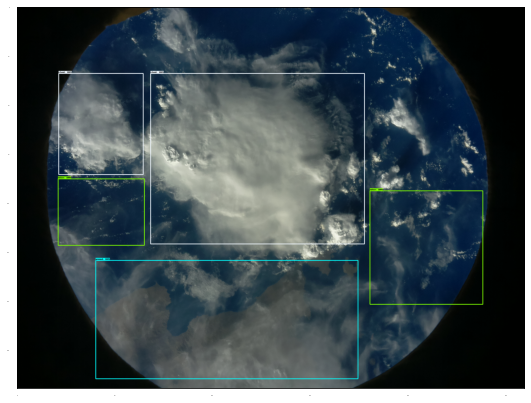

In [11]:
# Testing get_image_with_annotation function
data_folder = '../data/'
image_name = 'zz_astropi_1_photo_189'
get_image_with_annotation(image_name)

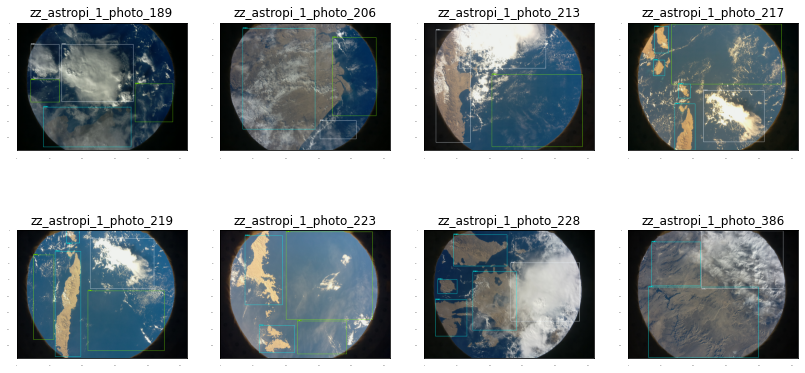

In [10]:
# Get all Astro Pi images with all annotations
images_name_np = [
  'zz_astropi_1_photo_189',
  'zz_astropi_1_photo_206',
  'zz_astropi_1_photo_213',
  'zz_astropi_1_photo_217',
  'zz_astropi_1_photo_219',
  'zz_astropi_1_photo_223',
  'zz_astropi_1_photo_228',
  'zz_astropi_1_photo_386'
]

# Visualizing all Astro pi Training dataset with annotations (8 x images)
for idx, image_name in enumerate(images_name_np):
  plt.subplot(2, 4, idx+1)
  plt.title(image_name)
  get_image_with_annotation(image_name)
plt.show()

# Data Prepaparation for Training

In [11]:
# Get name os astropi images
import os
astro_data = os.listdir(data_folder)
astro_images_file = [file for file in astro_data if os.path.splitext(file)[1] != '.xml'] # remove xml file
astro_images_file.sort()
astro_bbox_file = [file for file in astro_data if os.path.splitext(file)[1] != '.jpg']
astro_bbox_file.sort()

# Get a List of astropi numpy images
astro_images_list = []
for image_file in astro_images_file:
  img_pil = Image.open(data_folder+image_file)
  img_np = asarray(img_pil)
  astro_images_list.append(img_np)

# Get a numpy array of astropi numpy images
astro_images_np = np.array(astro_images_list) # images as numpy array in case needed

# Get a List of bboxes & classes for images
astro_gt_boxes_list = []
astro_classes_list = []
for astro_bboxes in astro_bbox_file: 
  classes,astro_gt_boxes=get_img_annotations(data_folder+astro_bboxes)
  astro_gt_boxes_np = np.array(astro_gt_boxes,dtype=np.float32)
  astro_gt_boxes_list.append(astro_gt_boxes_np)
  astro_classes_list.append(classes)

astro_class_id_list = []
for classes in astro_classes_list:
  class_id_list = []
  for label in classes:
    class_id = label_2_category[label]
    class_id_list
    class_id_list.append(class_id)
  astro_class_id_list.append(class_id_list)

In [12]:
print(f'Astro Images numpy array shape: {astro_images_np.shape}')
print(f'Astro ground truth box list length: {len(astro_gt_boxes_list)}')
print(f'Astro class list length: {len(astro_classes_list)}')

Astro Images numpy array shape: (8, 1944, 2592, 3)
Astro ground truth box list length: 8
Astro class list length: 8


In [13]:
# Prepare Data for Training: convert all numpy arrays & lists to TF tensors

astro_image_tensors = [] # images tensor list from numpy array
astro_gt_box_tensors = [] # bbox tensor list from gt_box list
astro_class_one_hot_tensors = [] # 1-hot class tensor list from class list

for (astro_image_np, astro_gt_box_np,astro_class_id) in zip(astro_images_list, astro_gt_boxes_list,astro_class_id_list):
  astro_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      astro_image_np, dtype=tf.float32), axis=0))
  astro_gt_box_tensors.append(tf.convert_to_tensor(astro_gt_box_np, dtype=tf.float32))
  astro_indexed_classes = tf.convert_to_tensor(astro_class_id,dtype=tf.int32)
  astro_class_one_hot_tensors.append(tf.one_hot(
      astro_indexed_classes, num_classes))
print('Done prepping data.')

2022-02-16 11:02:39.194663: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done prepping data.


# Load SSD Mobilenet

In [14]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
!if [ -d "models/research/object_detection/test_data/checkpoint" ]; then rm -Rf models/research/object_detection/test_data/checkpoint; fi
!mkdir models/research/object_detection/test_data/checkpoint
!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-01-26 10:30:06--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 2a00:1450:4007:81a::2010, 216.58.215.48
Connecting to download.tensorflow.org (download.tensorflow.org)|2a00:1450:4007:81a::2010|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.4’

ssd_mobilenet_v2_fp 100%[===================>]  19,56M  2,52MB/s    in 7,6s    

2022-01-26 10:30:15 (2,58 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz.4’ saved [20515344/20515344]



In [16]:
tf.keras.backend.clear_session()

# Pipeline & Checkpoint config
print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 3
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# This will be where we save checkpoint & config for TFLite conversion later.
output_directory = 'output/'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

# Load pipeline config and build a detection model.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes # to set number of classes to 3
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True) # the actual SSD Mobilenet Detection model
      
# Save new pipeline config
pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_proto, output_directory)

# To save checkpoint for TFLite conversion.
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 320, 320, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
INFO:tensorflow:Writing pipeline config file to output/pipeline.config
Weights restored!


# Train Model

In [17]:
# Training parameters

tf.keras.backend.set_learning_phase(True)

batch_size = 8
learning_rate = 0.15
num_batches = 30

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)



# Set up forward + backward pass for a single train step.

def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    shapes = tf.constant(batch_size * [[320, 320, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn


# Get SSD_Mobilenet preprocessed images
preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in astro_image_tensors], axis=0)

# Image type & shape transformation recap
print(f'Numpy image shape: {astro_images_list[0].shape}, type: {type(astro_images_list[0])}')
print(f'Tensor image shape: {astro_image_tensors[0].shape}, type: {type(astro_image_tensors[0])}')
print(f'Preprocessed image shape: {preprocessed_images[0].shape}, type: {type(preprocessed_images[0])}')

/Users/clement/.conda/envs/bluelens_2/lib/python3.7/site-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Numpy image shape: (1944, 2592, 3), type: <class 'numpy.ndarray'>
Tensor image shape: (1, 1944, 2592, 3), type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Preprocessed image shape: (320, 320, 3), type: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [21]:
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(astro_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]
  gt_boxes_list = [astro_gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [astro_class_one_hot_tensors[key] for key in example_keys]
  image_tensors = [astro_image_tensors[key] for key in example_keys]

In [ ]:
# SGD optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Training using train_step function
print('Start fine-tuning Training!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(astro_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Instantiate gt_boxes, gt_classes, images 
  gt_boxes_list = [astro_gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [astro_class_one_hot_tensors[key] for key in example_keys]
  image_tensors = [astro_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 2 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

ckpt_manager.save()
print('Checkpoint saved!')

In [ ]:
# Export trained model as savedModel into export folder with exporter_main_v2.py
!python models/research/object_detection/exporter_main_v2.py \
--pipeline_config_path output/pipeline.config \
--trained_checkpoint_dir output/checkpoint \
--output_directory export

# Inference from SavedModel

In [26]:
# Load savedModel
tf.keras.backend.clear_session()
model = tf.saved_model.load('export/saved_model')
model_fn = model.signatures['serving_default']

In [27]:
# Make prediction from "raw" image file
import os 

image_name = os.path.splitext(astro_images_file[0])[0]
image_path = data_folder+image_name+'.jpg'
image = Image.open(image_path)
image = np.asarray(image)
print(f'Raw image shape: {image.shape}')
input_tensor = tf.convert_to_tensor(image)
input_tensor = input_tensor[tf.newaxis,...]
output_dict = model_fn(input_tensor)
print('Inference successful.')

Raw image shape: (1944, 2592, 3)
Inference successful.


In [28]:
# Make prediction from preprocessed tf tensor image
print(f'Preprocessed image shape: {preprocessed_images[0].shape}')
input_tensor = preprocessed_images[0]
input_tensor = tf.cast(input_tensor,dtype=tf.uint8) # cast to uint8 as preprocessed_image is tf.float32
input_tensor = input_tensor[tf.newaxis,...]
output_dict = model_fn(input_tensor)
print('Inference successful.')

Preprocessed image shape: (320, 320, 3)
Inference successful.


In [22]:
def get_predictions(image_name):
  image_path = data_folder+image_name+'.jpg'
  image = Image.open(image_path)
  image = np.asarray(image)
  print(f'Raw image shape: {image.shape}')
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  output_dict = model_fn(input_tensor)
  print('Inference successful from get_predictions')
  return output_dict
  

def get_prediction_bboxes(image_name):
  image_path = data_folder+image_name+'.jpg'
  image = Image.open(image_path)
  image = np.asarray(image)
 # print(f'Raw image shape: {image.shape}')
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  output_dict = model_fn(input_tensor)
  bboxes = output_dict['detection_boxes'].numpy()
 # print('Inference successful.')
  return bboxes[0]


def get_prediction_classes(image_name):
  image_path = data_folder+image_name+'.jpg'
  image = Image.open(image_path)
  image = np.asarray(image)
 # print(f'Raw image shape: {image.shape}')
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  output_dict = model_fn(input_tensor)
  classes = output_dict['detection_classes'].numpy()
 # print('Inference successful.')
  return classes[0]


def get_prediction_scores(image_name):
  image_path = data_folder+image_name+'.jpg'
  image = Image.open(image_path)
  image = np.asarray(image)
 # print(f'Raw image shape: {image.shape}')
  input_tensor = tf.convert_to_tensor(image)
  input_tensor = input_tensor[tf.newaxis,...]
  output_dict = model_fn(input_tensor)
  classes = output_dict['detection_scores'].numpy()
 # print('Inference successful.')
  return classes[0]

In [23]:
image_path = data_folder+image_name+'.jpg'
image = Image.open(image_path)
image = np.asarray(image)
# print(f'Raw image shape: {image.shape}')
input_tensor = tf.convert_to_tensor(image)
input_tensor = input_tensor[tf.newaxis,...]
output_dict = model_fn(input_tensor)

In [24]:
# Get bbox prediction 
i = 'zz_astropi_1_photo_189'
predictions = get_predictions(i)
prediction_bboxes = get_prediction_bboxes(i)
prediction_classes = get_prediction_classes(i)
prediction_scores = get_prediction_scores(i)
object_nb = prediction_bboxes.shape[1]

Raw image shape: (1944, 2592, 3)
Inference successful from get_predictions


In [25]:
# Visualize Images with XML annotation prepared
def get_image_with_predictions(image_name):
  image_file = image_name + '.jpg'
  image = Image.open(data_folder+image_file)
  image_np = asarray(image)

  gt_box = get_prediction_bboxes(image_name)
  classes = get_prediction_classes(image_name)

  # plot_detections parameters
  image_np_with_annotations = image_np.copy()
  boxes = gt_box
  class_list = []
  for label in classes:
    class_list.append(int(label))
  classes = np.array(class_list,dtype=np.int32)
  scores = np.array([1.0]*gt_box.shape[0], dtype=np.float32)

  # Plotting detection
  plot_detections(
    image_np_with_annotations,
    boxes,
    classes,
    scores,
    category_index,
    image_name
    )

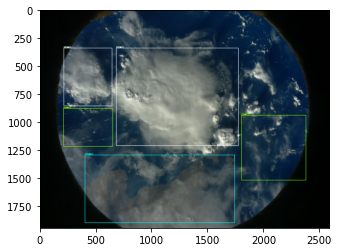

In [29]:
get_image_with_annotation(i)

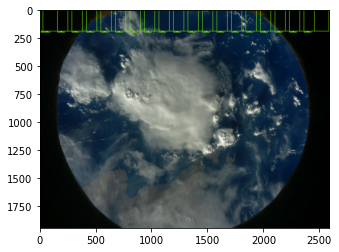

In [30]:
get_image_with_predictions(i)

In [31]:
i = 'zz_astropi_1_photo_189'
compare_images = [i,i]

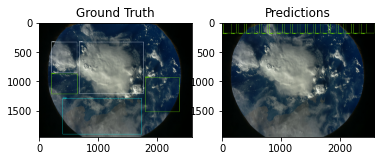

In [32]:
for idx, image in enumerate(compare_images):
  plt.subplot(1, 2, idx+1)
  if idx == 0:
    plt.title('Ground Truth')
    get_image_with_annotation(image)
  elif idx == 1:
    plt.title('Predictions')
    get_image_with_predictions(image)
plt.show()

# Model conversion to TFlite

In [ ]:
!python models/research/object_detection/export_tflite_graph_tf2.py \
  --pipeline_config_path output/pipeline.config \
  --trained_checkpoint_dir export/checkpoint \
  --output_directory tflite

In [ ]:
!tflite_convert --saved_model_dir=tflite/saved_model --output_file=tflite/model.tflite

# Inference from TFLite

In [33]:
tflite_model_path  = '../training/tflite/model.tflite'

In [34]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [35]:
# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[0.02575597 0.02575597 0.02575597 0.02575597 0.02575597 0.02575597
  0.02575597 0.02575597 0.02575597 0.02575597]]


In [ ]:
# tensorflow preprocess function
# https://github.com/tensorflow/models/blob/master/research/object_detection/core/preprocessor.py

In [36]:
input_tensor = preprocessed_images[0]
input_tensor = tf.cast(input_tensor,dtype=tf.float32)
image_tflite_np = input_tensor.numpy()

input_shape = input_details[0]['shape']
input_data = image_tflite_np.reshape(input_shape)

In [37]:
# Prepare image for SSD Mobilenet inference
input_tensor = preprocessed_images[0]
input_tensor = tf.cast(input_tensor,dtype=tf.float32)
image_tflite_np = input_tensor.numpy()


# Prepare data for TFLite inference
input_shape = input_details[0]['shape'] # tflite model input shape
input_data = image_tflite_np.reshape(input_shape) # tflite model input data as numpy

# This load input_data into tlfite interpreter
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# This output data from TFlite interpreter
output_data = interpreter.get_tensor(output_details[0]['index'])
#print(output_data.shape)
print("This is actually the scores prediction")
print(output_data)

This is actually the scores prediction
[[0.02575597 0.02575597 0.02575597 0.02575597 0.02575597 0.02575597
  0.02575597 0.02575597 0.02575597 0.02575597]]


In [38]:
# All useful Data from tflite inference: boxes, classes, scores
boxes = interpreter.get_tensor(output_details[1]['index'])
classes = interpreter.get_tensor(output_details[3]['index'])
scores = interpreter.get_tensor(output_details[0]['index'])

In [39]:
astro_images_list = []
for image_file in astro_images_file:
  img_pil = Image.open(data_folder+image_file)
  img_np = asarray(img_pil)
  astro_images_list.append(img_np)

In [41]:
def get_tflite_prepared_image(image_name):
  image_file = image_name + '.jpg'
  img_pil = Image.open(data_folder+image_file)
  img_np = asarray(img_pil)
  img_tensor = tf.expand_dims(tf.convert_to_tensor(
    img_np, dtype=tf.float32), axis=0)
  preprocessed_img =  detection_model.preprocess(img_tensor)[0]
  return preprocessed_img

In [ ]:
img0 = os.path.splitext(astro_images_file[0])[0]
get_tflite_prepared_image(img0)

In [43]:
def get_tflite_predictions(image_name,tflite_interpreter):
  # Prepare image
  preprocessed_img = get_tflite_prepared_image(image_name)
  input_tensor = preprocessed_img
  input_tensor = tf.cast(input_tensor,dtype=tf.float32)
  image_tflite_np = input_tensor.numpy()


  input_details = tflite_interpreter.get_input_details()
  output_details = tflite_interpreter.get_output_details() 

  # Prepare data for TFLite inference
  input_shape = input_details[0]['shape'] # tflite model input shape
  input_data = image_tflite_np.reshape(input_shape) # tflite model input data as numpy

  # This load input_data into tlfite interpreter
  interpreter.set_tensor(input_details[0]['index'], input_data)
  interpreter.invoke()

  # All useful Data from tflite inference: boxes, classes, scores
  boxes = interpreter.get_tensor(output_details[1]['index'])
  classes = interpreter.get_tensor(output_details[3]['index'])
  scores = interpreter.get_tensor(output_details[0]['index'])

  return boxes, classes, scores
  

In [44]:
boxes, classes, scores =  get_tflite_predictions(img0,interpreter)

# TPU Offload

In [ ]:
# https://coral.ai/docs/accelerator/get-started/#runtime-on-mac
curl -LO https://github.com/google-coral/libedgetpu/releases/download/release-grouper/edgetpu_runtime_20210726.zip
unzip edgetpu_runtime_20210726.zip
cd edgetpu_runtime
sudo bash install.sh

In [ ]:
! pip install tflite-runtime

In [ ]:
#https://github.com/freqtrade/freqtrade/issues/4281

In [ ]:
import tflite_runtime.interpreter as tflite

In [3]:
import os
edgetpu = os.getenv("LD_LIBRARY_PATH")

In [4]:
%env LD_LIBRARY_PATH=/usr/local/lib

env: LD_LIBRARY_PATH=/usr/local/lib


In [ ]:
tflite_model_path  = '../training/tflite/model.tflite'
interpreter = tflite.Interpreter(tflite_model_path,experimental_delegates=[tflite.load_delegate('libedgetpu.1.dylib')])

# Understanding TFLite model signature

In [ ]:
# https://www.tensorflow.org/lite/examples/object_detection/overview#model_customization
# tflite signature
# https://stackoverflow.com/questions/70635027/error-with-own-tensorflow-lite-object-detection-model-on-rpi

# GCP Annotations

In [335]:
import pandas as pd
gcp_annotations_df = pd.read_csv('../gcp/bounding_box.csv')

In [343]:
gcp_data_folder = '../gcp/gcpdata/'
gcp_gs_path = 'gs://cloud-ai-platform-9f241812-fd56-4ebf-8d1a-52490ea0b945/'
gcp_image_name = []
for image in gcp_annotations_df['imageGcsUri']:
  image_name = image.replace(gcp_gs_path,'')
  gcp_image_name.append(os.path.splitext(image_name)[0])

In [345]:
import json

def get_gcp_img_annotations(image_name, annotation_path,gcp_gs_path):
  gcp_annotations_df = pd.read_csv(annotation_path)
  gcp_image_path = gcp_gs_path+image_name+'.jpg'
  image_annotations = gcp_annotations_df[gcp_annotations_df['imageGcsUri']==gcp_image_path]
  image_annotation_json = image_annotations['boundingBoxAnnotations'].iloc[0].replace("\'", "\"")

  gcp_classes = []
  gcp_bboxes = []
  annotation_list = json.loads(image_annotation_json)
  
  for annotation in annotation_list:
    bbox_list = []
    gcp_classes.append(annotation['displayName'])
    bbox_list.append(annotation['yMin'])
    bbox_list.append(annotation['xMin'])
    bbox_list.append(annotation['yMax'])
    bbox_list.append(annotation['xMax'])
    gcp_bboxes.append(bbox_list)
  
  return gcp_classes, gcp_bboxes

In [256]:
label_2_category = {'cloud':0,'water':1,'ground':2,'ocean':'3'}

In [355]:
# Visualize Images with XML annotation prepared
def get_image_with_gcp_annotation(image_name,annotation_path,gcp_gs_path):
  image_file = image_name + '.jpg'
  image = Image.open(gcp_data_folder+image_file)
  image_np = asarray(image)
  labels, bboxes = get_gcp_img_annotations(image_name,annotation_path,gcp_gs_path) # get Labels + Bounding Boxes


  gt_box = np.array(bboxes,dtype=np.float32)

  # plot_detections parameters
  image_np_with_annotations = image_np.copy()
  boxes = gt_box
  class_list = []
  for label in labels:
    class_list.append(label_2_category[label])
  classes = np.array(class_list,dtype=np.int32)
  scores = np.array([1.0]*len(labels), dtype=np.float32)

  # Plotting detection
  plot_detections(
    image_np_with_annotations,
    boxes,
    classes,
    scores,
    category_index,
    image_name
    )

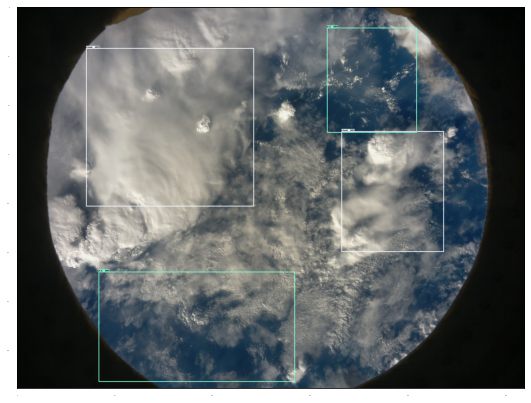

In [383]:
gcp_image_test = gcp_image_name[0]
gcp_gs_path = 'gs://cloud-ai-platform-9f241812-fd56-4ebf-8d1a-52490ea0b945/'
gcp_annotations_path = '../gcp/bounding_box.csv'

get_image_with_gcp_annotation(gcp_image_test,gcp_annotations_path,gcp_gs_path )

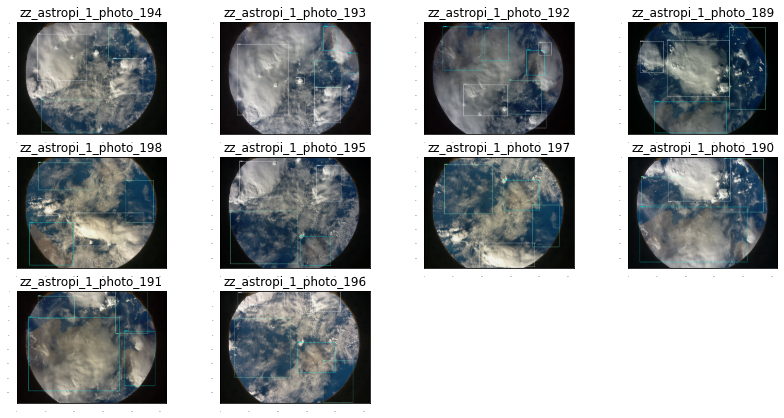

In [385]:
for idx, image_name in enumerate(gcp_image_name):
  plt.subplot(3, 4, idx+1)
  plt.title(image_name)
  get_image_with_gcp_annotation(os.path.splitext(image_name)[0],gcp_annotations_path,gcp_gs_path)
plt.show()